In [4]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt

# 对f(x)的Jacobian矩阵做SVD分解

In [7]:
#test_id_first = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl1_pl1_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"
def plot_singular(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(sqrtm(L))
            u, s, vt = np.linalg.svd(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_std = np.std(jac_arr, axis=0)


        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)
        plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)
    plt.grid()
    plt.xlabel("singular value index")
    plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular value")
    plt.legend(loc=[1.01,0])
    
#plot_singular(test_id_first, seeds=1, length=1)

In [9]:
from scipy.linalg import eig

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

test_id = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'    
def plot_singular_cum(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(sqrtm(L))
            u, s, vt = np.linalg.svd(mat)
            #mat = mat.T @ inv(msed) @ mat
#             eigenvalues, eigenvectors = eig(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    gn_dic = {}
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean = np.cumsum(jac_mean)
        jac_mean /= jac_mean[-1]
        gn = gini(jac_mean)
        gn_dic[str(1941+i//12)] = gn
        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)

    plt.xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular cumsum(normalized)")
    plt.legend(loc=[1.01,0])
    return gn_dic
    

({'2012': 0.3764095845850748,
  '2013': 0.3784956329242968,
  '2014': 0.3735414767398838,
  '2015': 0.37869484429286804,
  '2016': 0.37512656946614,
  '2017': 0.37491609686500316,
  '2018': 0.3796409446807204,
  '2019': 0.37755797359425913,
  '2020': 0.3792211621931929},
 {'2012': 0.3189045629866648,
  '2013': 0.31891166789279923,
  '2014': 0.3187116280166319,
  '2015': 0.31856957922419704,
  '2016': 0.3184716689311007,
  '2017': 0.31885670487789775,
  '2018': 0.319152044184593,
  '2019': 0.31865649865707824,
  '2020': 0.31885816973254766})

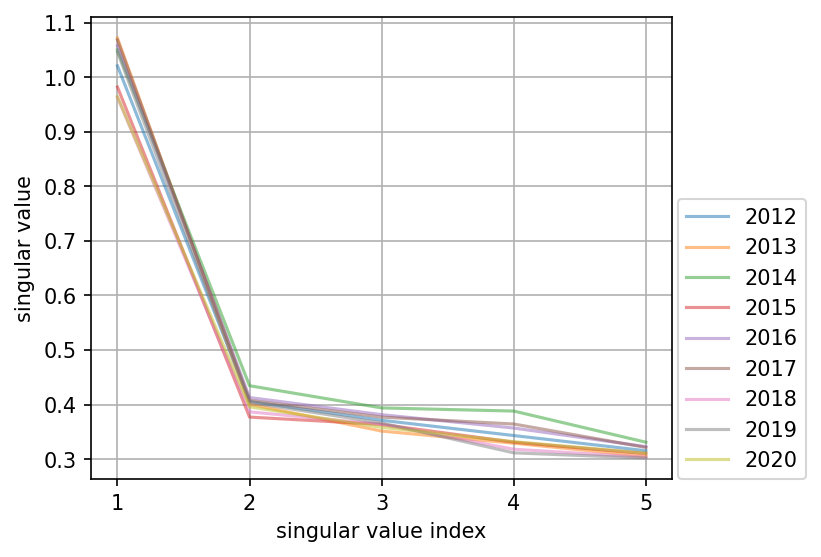

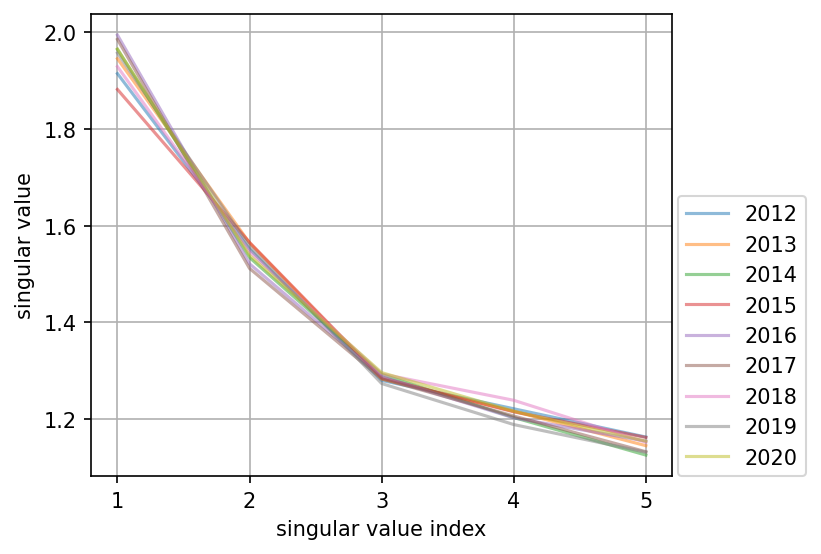

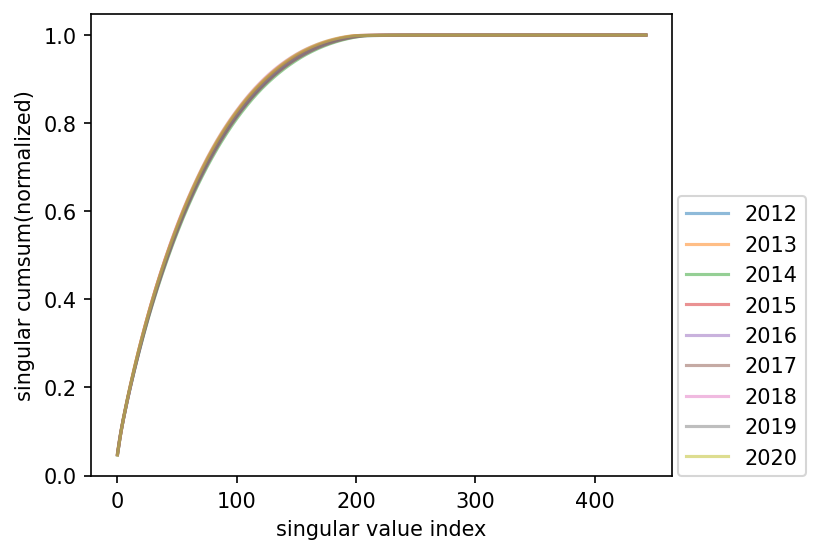

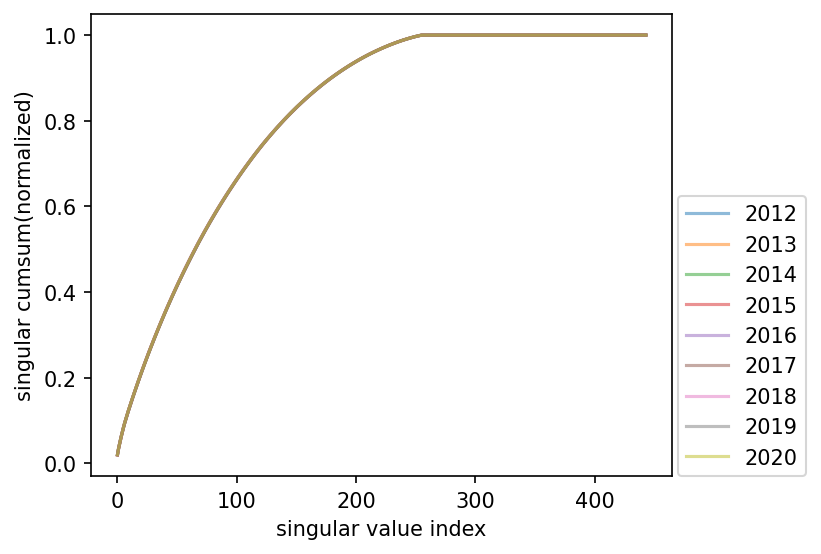

In [14]:
test_id = 'nn_forecast_data_mean_996_37_NN_cov_QBO_ftM_sl12_pl12_dm512_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'
test_id0 = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'
#test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
plot_singular(test_id0, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic0 = plot_singular_cum(test_id0, seeds=1, length=12, window=444, sigmas=False)
gn_dic, gn_dic0

{'2012': np.float64(0.4127916855838143),
 '2013': np.float64(0.4034898068651721),
 '2014': np.float64(0.39813582384693424),
 '2015': np.float64(0.4133884032923364),
 '2016': np.float64(0.3958277977029685),
 '2017': np.float64(0.3965376226459141),
 '2018': np.float64(0.4122596433601924),
 '2019': np.float64(0.40057195660876466),
 '2020': np.float64(0.4043368074273893)}

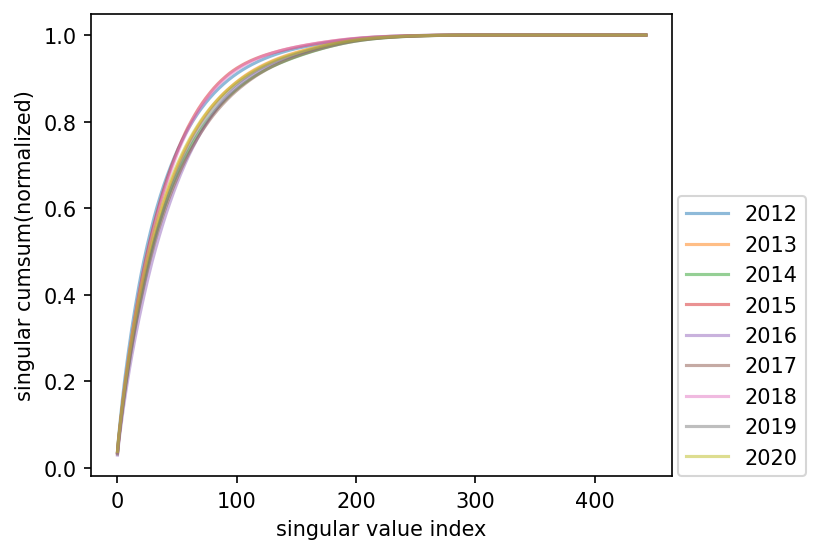

In [4]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4632452635422548),
 '2013': np.float64(0.47986298006084493),
 '2014': np.float64(0.46125682415531477),
 '2015': np.float64(0.4672404643840503),
 '2016': np.float64(0.4290361281506142),
 '2017': np.float64(0.4374336897944233),
 '2018': np.float64(0.449221766773663),
 '2019': np.float64(0.4295127090329538),
 '2020': np.float64(0.437953179509767)}

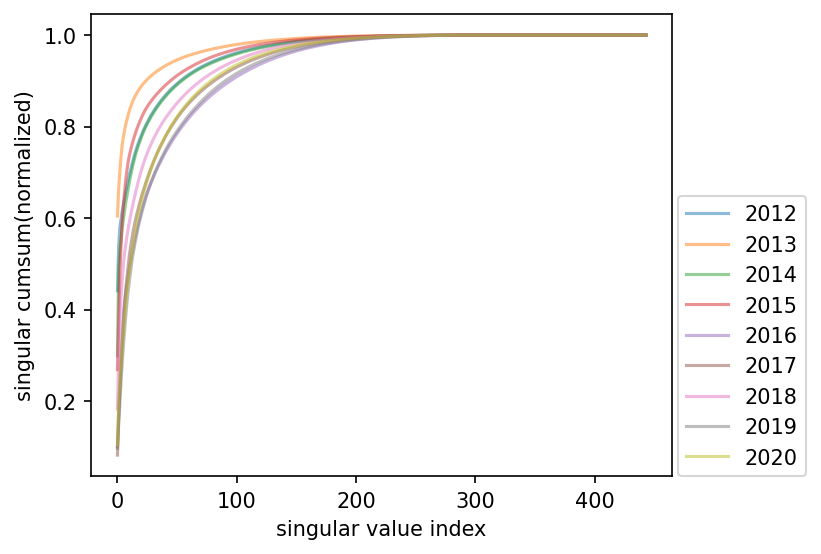

In [5]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

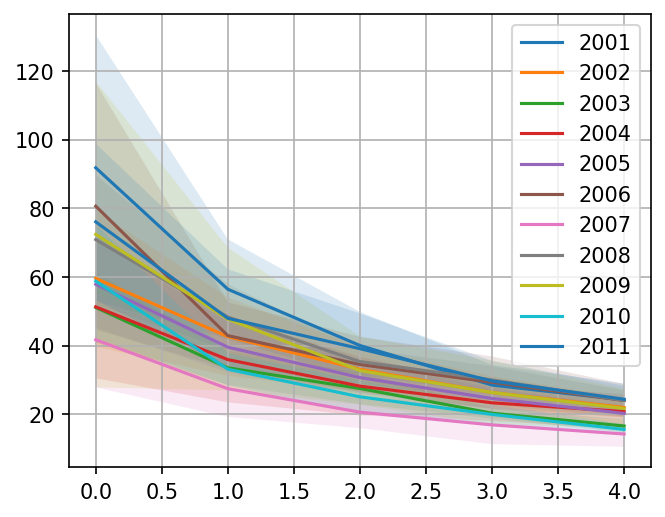

In [67]:
jacs = {i:[] for i in range(720, 852, 12)}
seeds = 10
for expid in range(seeds):
    test_id = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"+str(expid)
    for i in range(720, 852, 12):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(12*36, -1).astype(float)
        u, s, vt = np.linalg.svd(mat)
        jacs[i].append(s) 

plt.figure(figsize=(5,4),dpi=150)
for i in range(720, 852, 12):
    jac_arr = np.array(jacs[i])
    jac_mean = np.mean(jac_arr, axis=0)
    jac_std = np.std(jac_arr, axis=0)
    
    
    plt.plot(jac_mean[:5], label=str(1941+i//12))
    plt.fill_between(range(5), jac_mean[:5]+jac_std[:5], jac_mean[:5]-jac_std[:5], alpha=0.15)
plt.grid()
plt.legend()